In [6]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import locale
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from helpers import filter_region_year

locale.setlocale(locale.LC_ALL, "sl_SI.utf8")

'sl_SI.utf8'

In [8]:
df = pd.read_csv("podatki/wide_df.csv",parse_dates=['Datum']).drop(columns="Postaja")

In [10]:
def pollutant_graphing(
    df: pd.DataFrame,
    window_size=12,
    snov="",
    limit=None,
    directive=None,
):
    # Set the Seaborn theme for better aesthetics
    sns.set_theme(style="darkgrid")  # Choose your preferred theme
    df = filter_region_year(df, snov)

    df_agg = df.groupby(["Regija", "Datum"])[snov].mean().reset_index()
    df_agg = df_agg.pivot(index="Datum", columns="Regija", values=snov)

    

    rolling_mean = df_agg.rolling(window=window_size).mean()
    rolling_std = df_agg.rolling(window=window_size).std()

    num_regions = df_agg.shape[1]

    num_cols = 2
    num_rows = (num_regions + num_cols - 1) // num_cols

    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=(15, 4 * num_rows), sharey=True
    )
    axes = axes.flatten()

    for i, region in enumerate(df_agg.columns):
        ax = axes[i]

        # Add horizontal line if limit is set
        if limit:
            ax.axhline(limit, color="blue", linewidth=1.5)
            ax.annotate(
                f"{limit}ug/m3 omejitev",
                xy=(df_agg.index[-1], limit),  # Keep it on the limit line
                xytext=(0, 10),  # Position slightly below and to the right
                textcoords="offset points",
                ha="right",  # Horizontal Aligntment to the left
                va="top",  # Vertical Aligntment to the top
                color="darkblue",
                fontsize=9,
                fontweight="bold",
            )

        # Plot the data and the rolling mean
        ax.plot(df_agg.index, df_agg[region], label=f"Nivo {snov}", alpha=0.75)
        ax.plot(
            df_agg.index,
            rolling_mean[region],
            label="Drsno povprečje (letno)",
            color="red",
        )
        ax.fill_between(
            df_agg.index,
            rolling_mean[region] - rolling_std[region],
            rolling_mean[region] + rolling_std[region],
            color="orange",
            alpha=0.25,
            label="Drsni std. odklon (letni)",
        )

        # Add vertical line for directive if given
        if directive:
            directive_date = pd.to_datetime(directive)
            ax.axvline(
                directive_date, color="green", linestyle="--", label="NECD direktiva"
            )
            ax.annotate(
                f"NEC Direktiva {directive}",
                xy=(
                    directive_date,
                    df_agg.max(axis=None),
                ),  # Fine-tuned vertical position
                xytext=(5, -5),
                textcoords="offset points",
                ha="left",
                va="bottom",  # Changing to botton to avoid intersection with top plot border
                color="forestgreen",
                fontsize=9,
                fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6),
            )

        # Formatting and axis settings
        ax.set_xlabel("Čas")
        ax.set_ylabel(f"Nivo {snov}")
        ax.set_title(f"{region}")
        ax.grid(True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.tick_params(axis="x", rotation=45)
        min_date = pd.to_datetime(df_agg.index.min())
        max_date = pd.to_datetime(df_agg.index.max())

        # Add padding of ~3 months on each side
        pad = pd.DateOffset(months=3)
        ax.set_xlim([min_date - pad, max_date + pad])

    # Delete unused axes if the number of regions is smaller than the number of subplots
    if num_regions < len(axes):
        for i in range(num_regions, len(axes)):
            fig.delaxes(axes[i])

    # Combine legend handles and labels
    all_handles = []
    all_labels = []
    for ax in axes:  # Only use the real subplots, skip the empty ones
        handles, labels = ax.get_legend_handles_labels()
        for h, label in zip(handles, labels):
            if label not in all_labels:  # Avoid duplicates
                all_handles.append(h)
                all_labels.append(label)

    # Add combined legend below the subplots
    fig.legend(
        all_handles,
        all_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.025),
        ncol=len(all_labels),
    )

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig(f"grafi/trend_gibanja_{snov}_regije.png")
    plt.show()

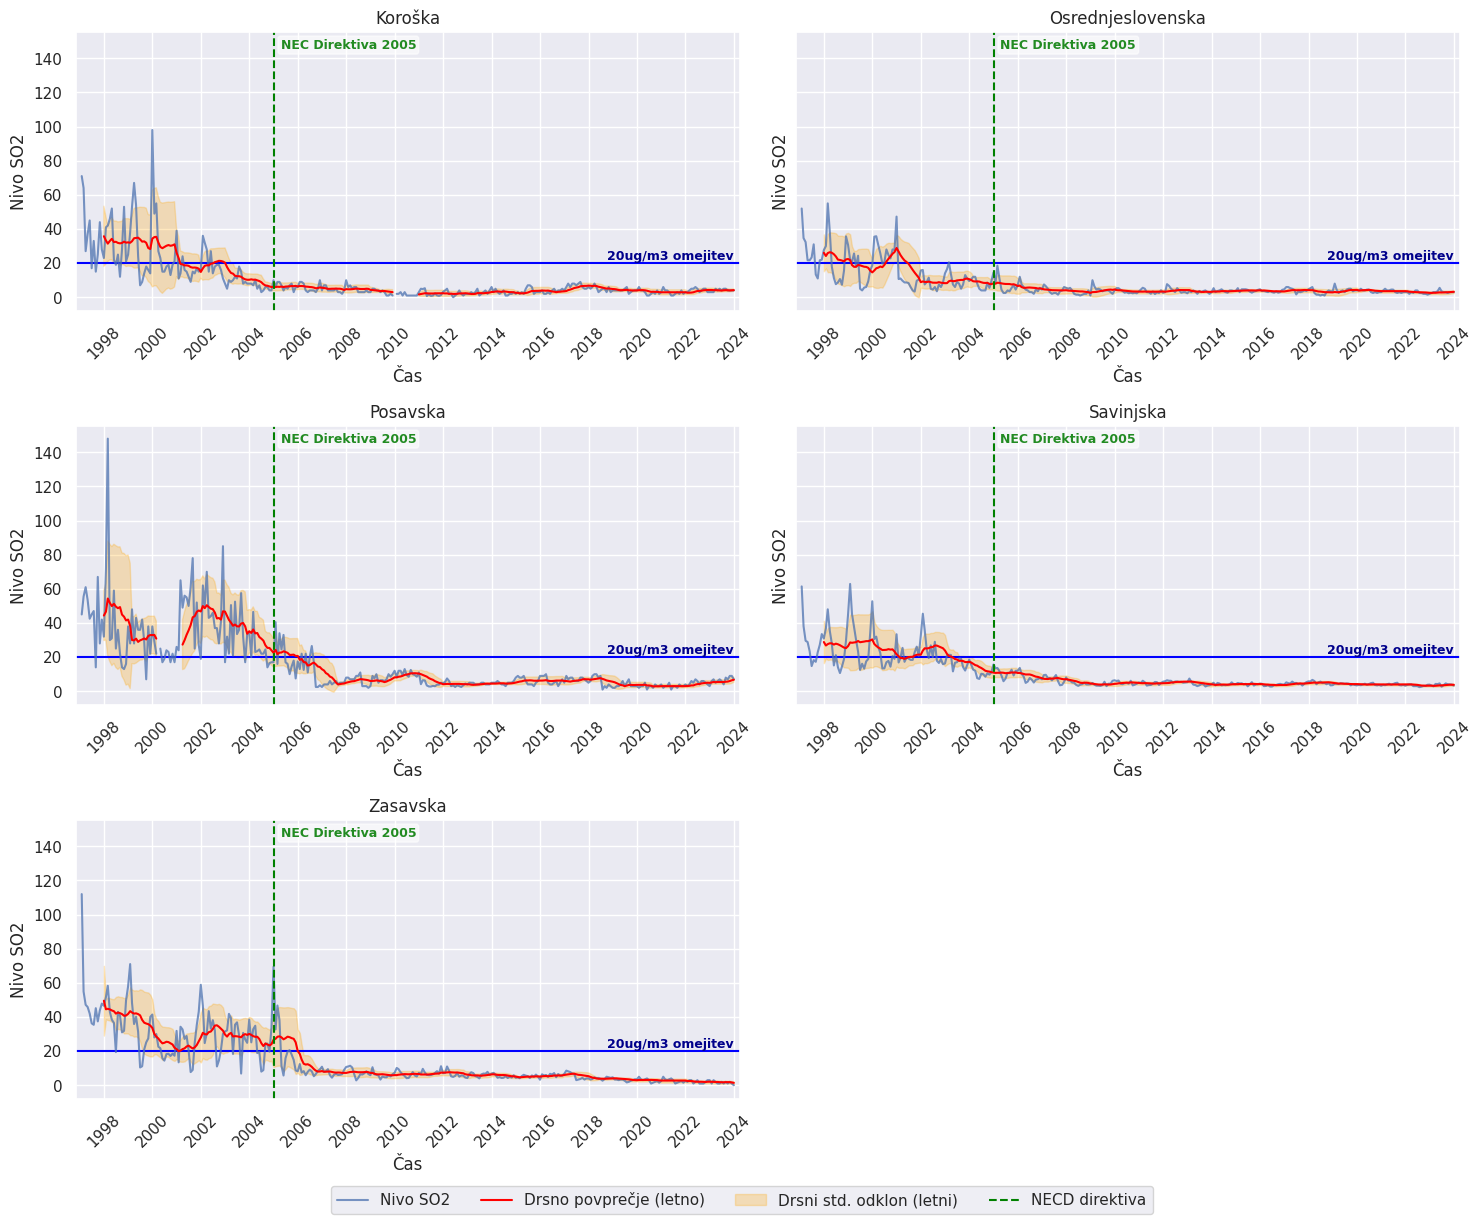

In [12]:
pollutant_graphing(df=df,snov="SO2",limit=20,directive='2005')

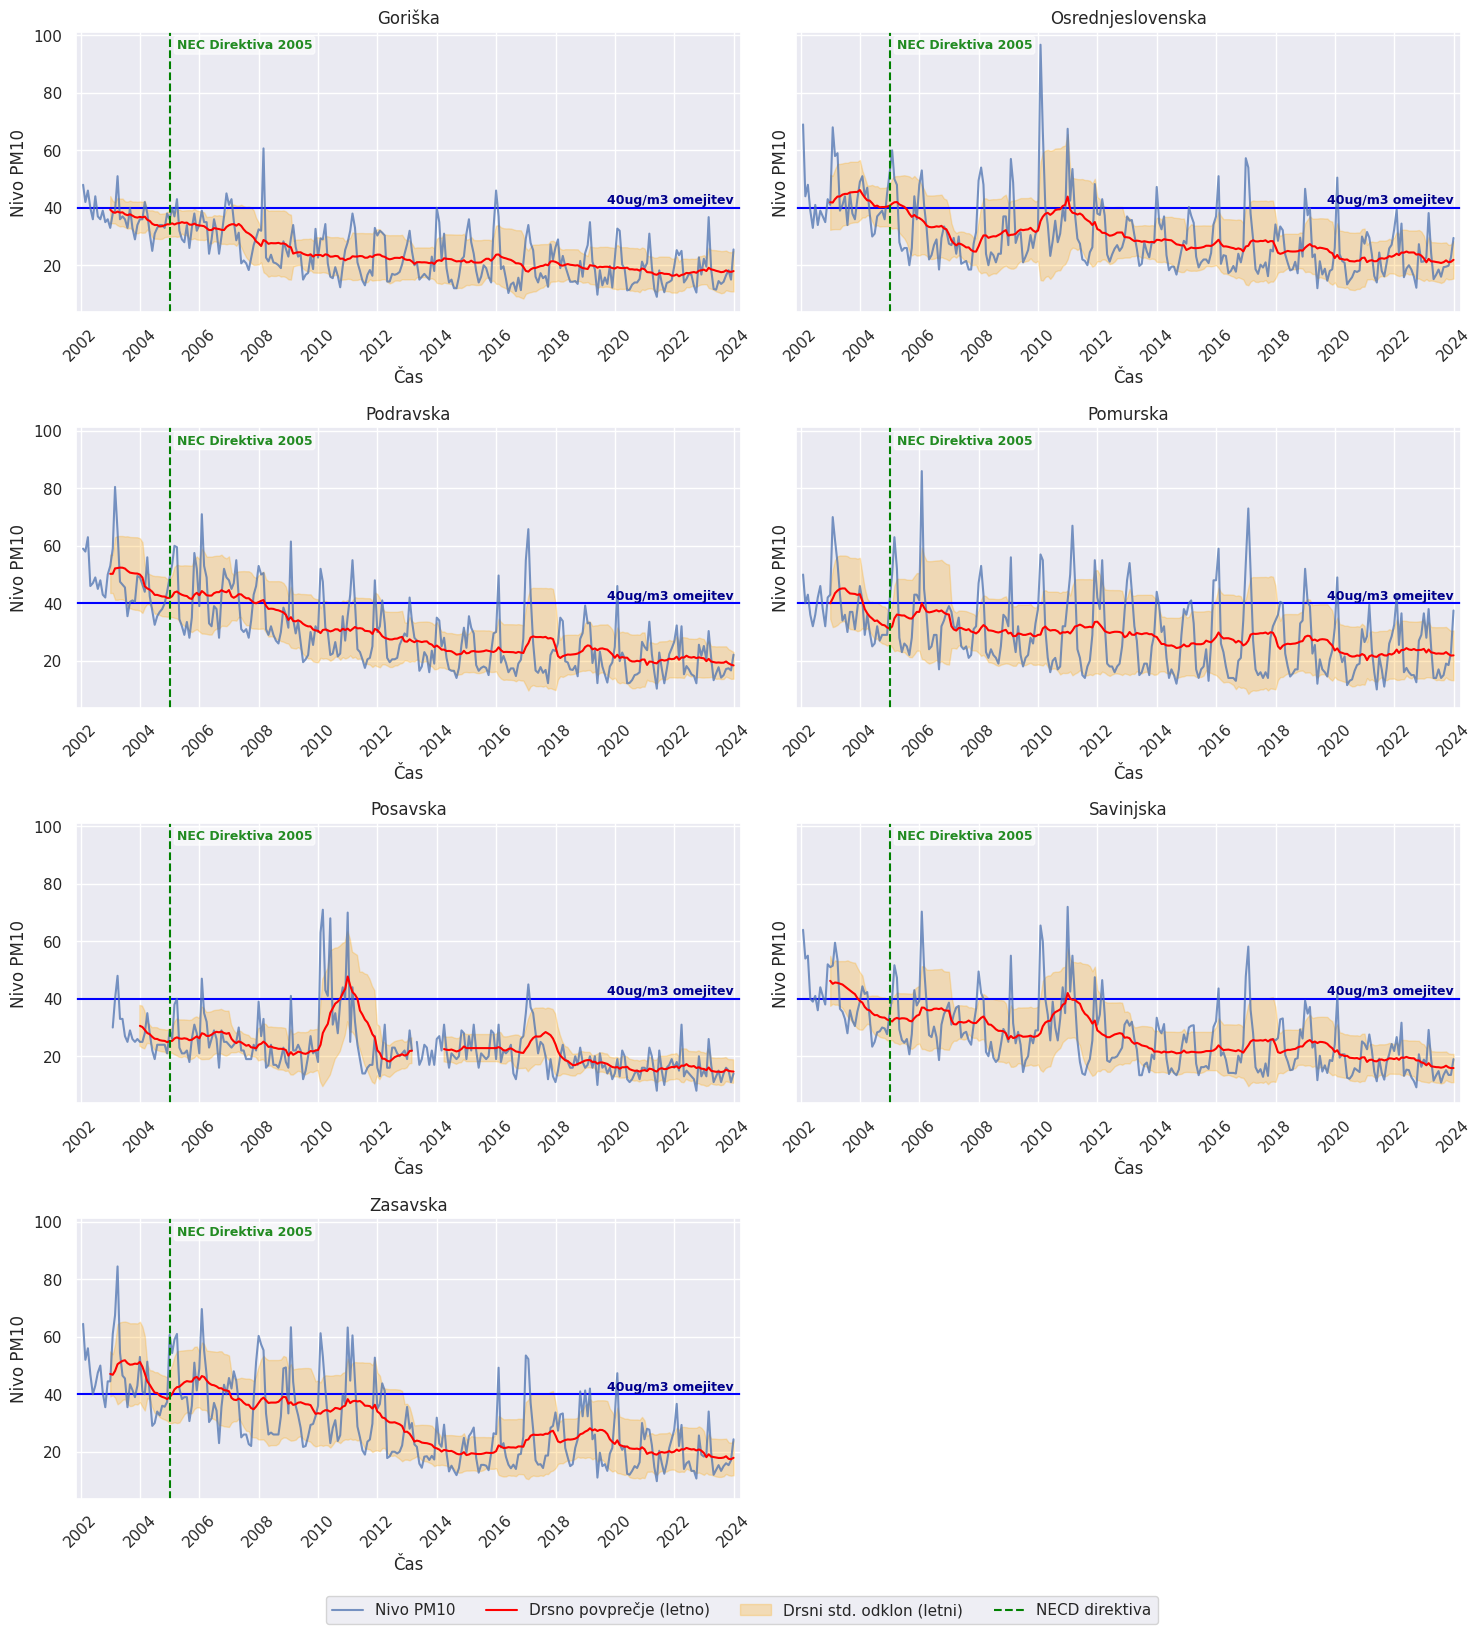

In [13]:
pollutant_graphing(df=df,snov="PM10",limit=40,directive='2005')


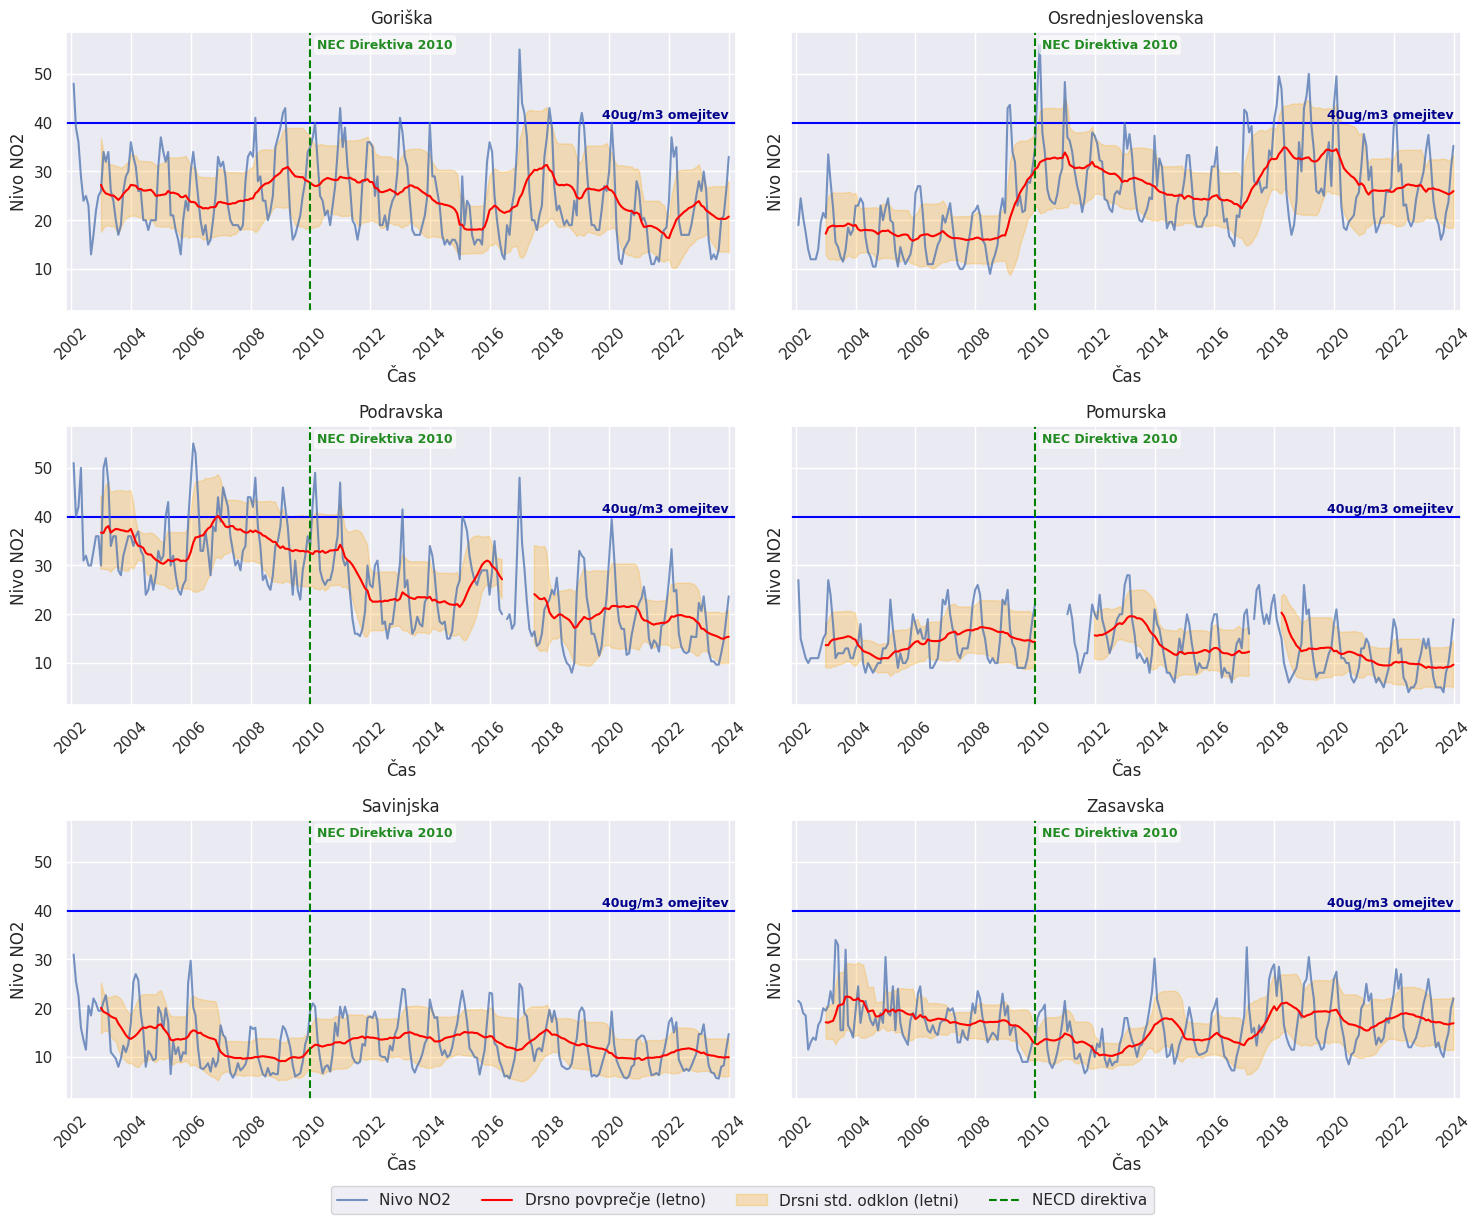

In [14]:
pollutant_graphing(df=df,snov="NO2",limit=40,directive='2010')